# Introduction
In the last notebook we saw that MLPs with multiple layers are pretty good at coming up with names. In this notebook we dive deep into the network to understand what is going on and how to do diagnostics.

We will go though the following:

* Initialization of Weights
* Activations

# Libraries

In [109]:
%matplotlib inline
%config IPCompleter.use_jedi=False

In [110]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Data
This step is pretty much equiviant of that in the previous notebook, so we will not go into depth on how the dataset is created.

### Reading the Data

In [111]:
# Reading names into a list
with open('../../data/names.txt', 'r') as f:
    names = f.readlines()
    names = [name.strip() for name in names]

### Creating Vocabulary

In [112]:
# Building the vocabulary (character to/from index)
chars = sorted(list(set(''.join(names))))
chr_to_idx = {s:i+1 for i,s in enumerate(chars)}; print(chr_to_idx)
chr_to_idx['.'] = 0
idx_to_chr = {i:s for s,i in chr_to_idx.items()}; print(idx_to_chr)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### Preparing Dataset

In [113]:
def build_dataset(words: list, block_size: int = 3, verbose: bool = False) -> tuple:
    """
    Description:
        Take a list of words and creates Xs and Ys give
        a block size. E.g. block_size=3 for emma would 
        result in:
            ... ---> e  
            ..e ---> m  
            .em ---> m  
            emm ---> a  
            mma ---> . 
        Stored in a (n, 3) tensor
    Inputs:
        words: List of words
        block_size: The context window
        verbose: Where to print the outputs
    Ouputs:
        A (n, block_size) tensor with Xs
        A (n) tensor with Ys
    """
    X, Y = [], []
    for word in words:
        if verbose:
            print(word)
        context = [0] * block_size
        for char in word + '.':
            idx = chr_to_idx[char]
            X.append(context)
            Y.append(idx)
            if verbose:
                print(''.join(idx_to_chr[i] for i in context), idx_to_chr[idx])
            context = context[1:] + [idx]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    return X, Y

In [114]:
# Putting names in random order
random.shuffle(names)

# Creating split indices
n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))

In [115]:
# Building training, validation and test sets
Xtr, Ytr = build_dataset(names[:n1]); print(Ytr.size())
Xval, Yval = build_dataset(names[n1:n2]); print(Yval.size())
Xtest, Ytest = build_dataset(names[n2:]); print(Ytest.size())

torch.Size([182462])
torch.Size([22922])
torch.Size([22762])


# Building Network
We build a similar MLP to that in the previous notebook.

In [116]:
n_embd = 10
n_hidden = 200
block_size = 3
vocab_size = len(chr_to_idx)

# Lookup table
C = torch.randn([vocab_size, n_embd])

# Weights and biases
W1 = torch.randn([n_embd * block_size, n_hidden])
b1 = torch.randn([n_hidden])
W2 = torch.randn([n_hidden, vocab_size])
b2 = torch.randn([vocab_size])

# Placing parameters in list
parameters = [C, W1, b1, W2, b2]

# Enabling gradients
for p in parameters:
    p.requires_grad = True
print("Number of parameters: " + str(sum(p.nelement() for p in parameters)))

Number of parameters: 11897


# Training
We use the same training loop as in the previous notebook. We have, however, refactored a bit, and defined a method for calculating the loss without messing with the gradients.

In [117]:
@torch.no_grad() # Decorator disables gradient tracking
def split_loss(split: str = 'train', print_loss: bool = False) -> None:
    """
    Description:
        Prints the loss of a chosen split
    Inputs:
        split: train, valid, or test
    """
    x,y = {
        'train': (Xtr, Ytr),
        'valid': (Xval, Yval),
        'test': (Xtest, Ytest),
    }[split]
    emb = C[x]
    emb_cat = emb.view(emb.shape[0], -1)
    h_preactiv = emb_cat @ W1 + b1
    h = torch.tanh(h_preactiv)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y) 
    
    if print_loss:
        print(split, loss.item())
    else :
        return loss.item()

In [118]:
losses = {"Train": [], "Val": []}

In [119]:
epochs = 100000
batch_size = 64
lr = 0.1

for epoch in range(epochs):
    
    # Minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # Forward pass
    emb = C[Xb]
    emb_cat = emb.view(emb.shape[0], -1)
    h_preactiv = emb_cat @ W1 + b1
    h = torch.tanh(h_preactiv)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)    
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    ## Update
    if epoch < 30000:
        for p in parameters:
            p.data += -lr * p.grad
    elif epoch < 60000:
        for p in parameters:
            p.data += -lr * 0.1 * p.grad
    else:
        for p in parameters:
            p.data += -lr * 0.01 * p.grad        
        
    # Tracking stats
    losses["Train"].append(loss.item())
    #losses["Val"].append(split_loss("valid"))
    
    # Printing stats
    if not epoch % 100000:
        print(f"{epoch:7d}/{epochs:7d}: {loss.item():.4f}")

      0/ 100000: 23.0473
   1000/ 100000: 3.4191
   2000/ 100000: 3.0487
   3000/ 100000: 2.4135
   4000/ 100000: 2.7523
   5000/ 100000: 2.3663
   6000/ 100000: 2.6912
   7000/ 100000: 2.5332
   8000/ 100000: 2.4685
   9000/ 100000: 2.0107
  10000/ 100000: 2.3283
  11000/ 100000: 2.3131
  12000/ 100000: 2.4321
  13000/ 100000: 2.4866
  14000/ 100000: 2.5920
  15000/ 100000: 2.0891
  16000/ 100000: 2.3527
  17000/ 100000: 2.6379
  18000/ 100000: 2.2953
  19000/ 100000: 2.1407
  20000/ 100000: 2.6083
  21000/ 100000: 2.6699
  22000/ 100000: 2.4416
  23000/ 100000: 2.2343
  24000/ 100000: 2.4599
  25000/ 100000: 2.4990
  26000/ 100000: 2.0231
  27000/ 100000: 2.4127
  28000/ 100000: 2.1419
  29000/ 100000: 2.1188
  30000/ 100000: 1.9909
  31000/ 100000: 2.2432
  32000/ 100000: 2.1213
  33000/ 100000: 2.3120
  34000/ 100000: 2.1642
  35000/ 100000: 2.3642
  36000/ 100000: 2.1081
  37000/ 100000: 2.2514
  38000/ 100000: 2.1755
  39000/ 100000: 2.4213
  40000/ 100000: 2.3801
  41000/ 100000

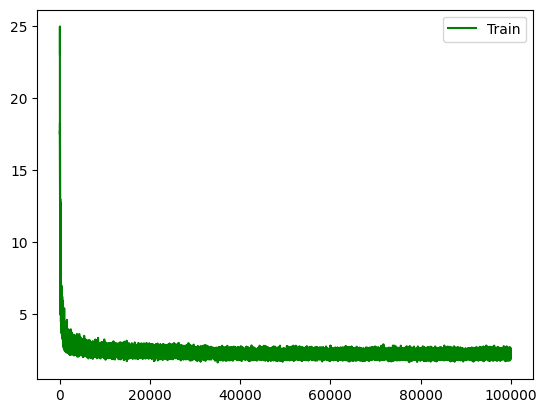

In [120]:
# Plotting training and validation losses
xs = list(range(1, len(losses["Train"])+1))
plt.plot(xs, losses["Train"], label = "Train", color="green")
#plt.plot(xs, losses["Val"], label = "Valid", color="red")
plt.legend()
plt.show()

In [121]:
split_loss("train", print_loss=True)
split_loss("valid", print_loss=True)

train 2.197010040283203
valid 2.2241969108581543


# Generating Names

In [122]:
number_of_names = 20

for _ in range(number_of_names):
    
    char_idx = []
    context = [0] * block_size # Initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # Embeddings for context
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [idx]
        char_idx.append(idx)
        if idx == 0:
            break
    
    print(''.join(idx_to_chr[char_idx] for char_idx in char_idx))

esa.
braana.
haa.
vaohina.
ezelli.
skaelin.
alon.
asia.
jase.
horathen.
bramin.
valya.
tattlyna.
mhi.
dariberra.
maghlery.
adje.
yural.
saydlkilavelia.
atded.


# Analyses
We will now go through the model above and find out how to make it better.

### Initialization
If we look at the losses output by the model, we can see that the initial loss is way higher than all the training losses. This is ofcause expected, at we initialize the weights using random numbers. But there are things we can do to ensure a better initial loss. E.g. we could make sure the initial model predicts the 27 output-letters uniformly. We will start out by calculating the expected initial loss if the propabilities of the outputs were uniformly distributed. Go to notebook 1. if you want to see how the loss was calculated manually.

In [123]:
# Estimating the loss at uniform distribution
-torch.tensor(1/27).log()

tensor(3.2958)

We can illustrate this example further by comparing the loss for a uniformly distributed tensor vs a randomly initialized tensor.

In [124]:
# Uniform
logits = torch.tensor([0.15,0.15,0.15,0.15])
probs = torch.softmax(logits, dim=0)
losses = -probs.log()
logits, probs, losses

(tensor([0.1500, 0.1500, 0.1500, 0.1500]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor([1.3863, 1.3863, 1.3863, 1.3863]))

In [125]:
# Random
logits = torch.randn(4)
probs = torch.softmax(logits, dim=0)
losses = -probs.log()
logits, probs, losses

(tensor([-0.0841, -1.3557, -0.4450, -0.3075]),
 tensor([0.3601, 0.1010, 0.2510, 0.2880]),
 tensor([1.0215, 2.2930, 1.3824, 1.2448]))

We can see that the logits of the randomly initialized tensor have more "extreme" values than those of the uniform distribution. If we break the training loop after one epoch, we can inspect the logits there, and conclude the same even more so.

We will now attempt to find a way to make the initial loss lower by initializing the weights, such that the logits will uniformly distributed (most easily to get them to all to be close to zero).

We will work out way backworth through the forward pass:

1. logits = h @ W2 + b2
  * We can see that the biases **b2** adds directly to the logits. By initializing **b2** as zero, we can move the logits closer to zero.
  * We can also scale down **W2** to get the logits closer to zero.

In [131]:
# Attempt 1: Logits towards zero
n_embd = 10
n_hidden = 200
block_size = 3
vocab_size = len(chr_to_idx)

# Lookup table
C = torch.randn([vocab_size, n_embd])

# Weights and biases
W1 = torch.randn([n_embd * block_size, n_hidden])
b1 = torch.randn([n_hidden])
W2 = torch.randn([n_hidden, vocab_size]) * 0.01
b2 = torch.randn([vocab_size]) * 0

# Placing parameters in list
parameters = [C, W1, b1, W2, b2]

# Enabling gradients
for p in parameters:
    p.requires_grad = True
print("Number of parameters: " + str(sum(p.nelement() for p in parameters)))

Number of parameters: 11897


In [132]:
# Attempt 1: Training
losses = {"Train": [], "Val": []}
epochs = 100000
batch_size = 64
lr = 0.1

for epoch in range(epochs):
    
    # Minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # Forward pass
    emb = C[Xb]
    emb_cat = emb.view(emb.shape[0], -1)
    h_preactiv = emb_cat @ W1 + b1
    h = torch.tanh(h_preactiv)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)    
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    ## Update
    if epoch < 30000:
        for p in parameters:
            p.data += -lr * p.grad
    elif epoch < 60000:
        for p in parameters:
            p.data += -lr * 0.1 * p.grad
    else:
        for p in parameters:
            p.data += -lr * 0.01 * p.grad        
        
    # Tracking stats
    losses["Train"].append(loss.item())
    #losses["Val"].append(split_loss("valid"))
    
    # Printing stats
    if not epoch % 10000:
        print(f"{epoch:7d}/{epochs:7d}: {loss.item():.4f}")

split_loss('train', print_loss=True)
split_loss('valid', print_loss=True)

      0/ 100000: 3.3215
  10000/ 100000: 2.1920
  20000/ 100000: 2.2812
  30000/ 100000: 2.3799
  40000/ 100000: 2.1828
  50000/ 100000: 2.0874
  60000/ 100000: 1.9534
  70000/ 100000: 2.0219
  80000/ 100000: 2.0017
  90000/ 100000: 2.1817
train 2.1081840991973877
valid 2.158094882965088


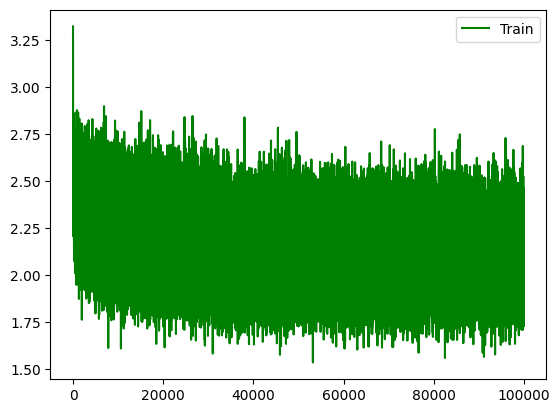

In [133]:
# Attempt 1: Plotting training and validation losses
xs = list(range(1, len(losses["Train"])+1))
plt.plot(xs, losses["Train"], label = "Train", color="green")
#plt.plot(xs, losses["Val"], label = "Valid", color="red")
plt.legend()
plt.show()

In [ ]:
# https://www.youtube.com/watch?v=P6sfmUTpUmc